# Projet SD-201 : Predicting NFL Injuries

In [1]:
!pip install pandasql
!pip install -U imbalanced-learn
!pip install -U pandasql
!pip install pysqldf
!pip install tree

***
## Table of content
* [1. Overview of the dataset](#chapter1) 
    * [1.1 Raw data](#section1_1)
    * [1.2 Erasing NaN values of the dataset](#section1_1)
    * [1.3 Adjusting data to our issue](#section1_1)
        * [1.3.a Creating some columns](#sub_section_1_3_a)
        * [1.3.b Creating dummy variable](#sub_section_1_3_b)
    * [1.4 Data visualization](#section1_4)
        * [1.4.a Looking for outliers](#sub_section_1_4_a)
        * [1.4.b Unrealistic distribution of positions](#sub_section_1_4_b)
        * [1.4.c Correlation between features](#sub_section_1_4_c)
* [2. Naive approach : ML without dealing with class imbalance](#chapter2)
    * [2.1 Pre-processing](#section2_1)
        * [2.1.a Useful Pre-processing](#sub_section_2_1_a)
        * [2.1.a Train Test Split](#sub_section_2_1_b)
    * [2.2 First Classification Method : KNN-Method](#section2_2)
    * [2.3 Second Classification Method : Decision Tree](#section2_3)
        * [2.3.a Implementing Decision Tree](#sub_section_2_3_a)
        * [2.3.b Evaluation Decision](#sub_section_2_3_b)
        * [2.3.c Evaluation with Confusion Matrix](#sub_section_2_3_c)
    * [2.4 Third Classification Method : Random Forest](#section2_4)
        * [2.4.a Implementing Decision Tree](#sub_section_2_4_a)
        * [2.4.b Evaluation Decision](#sub_section_2_4_b)
        * [2.4.c Evaluation with Confusion Matrix](#sub_section_2_4_c)
* [3. ML with dealing with Class Imbalance](#chapter3)
    * [3.1 Dealing with Class Imbalance](#section3_1)
    * [3.2 First Classification Method : Decision Tree](#section3_2)
    * [3.3 Second Classification Method : Random Forest](#section3_3)
* [Conclusion](#conclusion)

***
# Importing librairies

In [2]:
import pandasql as ps
from pandasql import sqldf
import pysqldf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn

from collections import Counter
from matplotlib import pyplot
from numpy import where

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix

In [3]:
import imblearn

In [4]:
import seaborn as sns

In [5]:
import time
from sklearn.model_selection import RandomizedSearchCV
from sklearn import tree

***
## 1. Overview of the dataset <a class="anchor" id="chapter1"></a>

### 1.1 Raw data <a class="anchor" id="section1_1"></a>

Let's see what our dataset is, and the initial features that characterize our dataset. 

In [6]:
####

#Do not re execute each time !!

####

#Importing the data
InjuryRecord = pd.read_csv('../Data/nfl-playing-surface-analytics/InjuryRecord.csv')
PL = pd.read_csv('../Data/nfl-playing-surface-analytics/PlayList.csv', chunksize=20000)
PL = pd.concat(PL)
PlayerTrackData = pd.read_csv('../Data/nfl-playing-surface-analytics/PlayerTrackData.csv', chunksize=20000*6)
PlayerTrackData = pd.concat(PlayerTrackData)

#N.B. : the only interest in using chunksize and concats is to make the process faster

In [7]:
InjuryRecord.head()

,PlayerKey,GameID,PlayKey,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42
0,39873,39873-4,39873-4-32,Knee,Synthetic,1,1,1,1
1,46074,46074-7,46074-7-26,Knee,Natural,1,1,0,0
2,36557,36557-1,36557-1-70,Ankle,Synthetic,1,1,1,1
3,46646,46646-3,46646-3-30,Ankle,Natural,1,0,0,0
4,43532,43532-5,43532-5-69,Ankle,Synthetic,1,1,1,1


In [8]:
PL.head()

,PlayerKey,GameID,PlayKey,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup
0,26624,26624-1,26624-1-1,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,1,QB,QB
1,26624,26624-1,26624-1-2,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,2,QB,QB
2,26624,26624-1,26624-1-3,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Rush,3,QB,QB
3,26624,26624-1,26624-1-4,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Rush,4,QB,QB
4,26624,26624-1,26624-1-5,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,5,QB,QB


In [9]:
PlayerTrackData.head()

,PlayKey,time,event,x,y,dir,dis,o,s
0,26624-1-1,0.0,huddle_start_offense,87.46,28.93,288.24,0.01,262.33,0.13
1,26624-1-1,0.1,NaN,87.45,28.92,283.91,0.01,261.69,0.12
2,26624-1-1,0.2,NaN,87.44,28.92,280.40,0.01,261.17,0.12
3,26624-1-1,0.3,NaN,87.44,28.92,278.79,0.01,260.66,0.10
4,26624-1-1,0.4,NaN,87.44,28.92,275.44,0.01,260.27,0.09


### 1.2 Erasing NaN values of the dataset <a class="anchor" id="section1_2"></a>

First, we drop the rows without the index PlayKey. Before, we check the number of rows we will drop is not too big.

In [10]:
InjuryRecord['PlayKey'].isna().sum()

28

In [11]:
InjuryRecord = InjuryRecord.dropna(subset=['PlayKey'])

The dataset is too heavy so we extract a part of the dataset. 

In [12]:
PlayList = PL.sample(n=int(PL.shape[0]/6)) #unfortunately we can't use the full dataset (too heavy)
PlayList = PlayList.append(PL[PL['PlayKey'].isin(InjuryRecord['PlayKey'])]).drop_duplicates(subset='PlayKey')

/var/folders/0f/xr7tmt4j36s_824n5z1c8bw80000gn/T/ipykernel_14372/2136971304.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  PlayList = PlayList.append(PL[PL['PlayKey'].isin(InjuryRecord['PlayKey'])]).drop_duplicates(subset='PlayKey')


We only keep the relevant rows of PlayerTrackData, i.e. the ones that are also in InjuryRecord.

In [13]:
PlayerTrackData = PlayerTrackData[PlayerTrackData['PlayKey'].isin(PlayList['PlayKey'])]

In [14]:
data = PlayList.copy()

In [15]:
data.shape

(44562, 14)

In [16]:
#Dropping out data we considered irrelevant/useless in the decision process
data.drop(["PositionGroup"], axis=1, inplace=True)

#Filtering out null and nan PlayTypes
data = data.loc[(data["PlayType"] != "0") & (data["PlayType"] != "nan")]

#Filtering null Positions
data = data.loc[(data["Position"] != "Missing Data")]

### 1.3 Adjusting the dataset to our issue <a class="anchor" id="section1_3"></a>

There are features which are not useable in the form given in the initial dataset, such as the different names of the `Position`. But, these features get information which are important to our analysis. We have to change the form of these feature into a useable form. So :  
- We have to add some columns in the dataset with the useable forms of the data, 
- We have to convert categorical feature into numerical one by creating dummy variable.

#### 1.3.a Creating some columns <a class="anchor" id="sub_section_1_3_a"></a>

In [17]:
#We can aggregate values of the column Position (we want to know the position of each player, 
#currently the column contain the position plus the side of the player)
data["Position"].unique

<bound method Series.unique of 98104     WR
43793     FS
156671    DT
107854     G
189820    CB
          ..
258413    RB
260999    WR
262514    CB
264404    LB
266263    CB
Name: Position, Length: 44500, dtype: object>

In [18]:
#Adding columns containing computed data

#Aggregating postions acronyms into roster categories in order to be able to ask the question :
#Was the player playing in his usual postion during this play ?
data.loc[data["Position"].isin(["C", "T","G"]),'Position'] = "Offensive Lineman"
data.loc[data["Position"].isin(["MLB", "OLB", "ILB", "LB"]),'Position'] = "Linebacker"
data.loc[data["Position"].isin(["WR"]),'Position'] = "Wide Receiver"
data.loc[data["Position"].isin(["S", "SS", "FS"]),'Position'] = "Safety"
data.loc[data["Position"].isin(["DT", "DE", "NT"]),'Position'] = "Defensive Lineman"
data.loc[data["Position"].isin(["CB", "DB"]),'Position'] = "Cornerback"
data.loc[data["Position"].isin(["HB", "RB"]),'Position'] = "Running Back"
data.loc[data["Position"].isin(["TE"]),'Position'] = "Tight End"
data.loc[data["Position"].isin(["QB"]),'Position'] = "Quarterback"
data.loc[data["Position"].isin(["K", "P"]),'Position'] = "Kicker"

#Creation of a new column : if the player was at his usual position
data = data.assign(UsualPosition=(data['RosterPosition'] == data['Position']))

#Let's drop Roster Position, we have now used all the information useful this feature get to help our analysis
data.drop(["RosterPosition"], axis=1, inplace=True)

In [19]:
#Creation of a new column : if the player was injured before
ps.pysqldf = lambda q: sqldf(q, globals())
query = "SELECT PL.PlayKey FROM PlayList AS PL JOIN InjuryRecord AS IR ON PL.PlayerKey = IR.PlayerKey WHERE (PL.GameID != IR.GameID AND PL.PlayerDay > IFNULL((SELECT PL2.PlayerDay FROM PlayList AS PL2 WHERE PL2.PlayKey = IR.PlayKey), 0))"
injured_before = ps.pysqldf(query)
data = data.assign(injured_before=data['PlayKey'].isin(injured_before))

#Eventually we drop PlayDay which will not be used later
data.drop(['PlayerDay'], axis=1,inplace=True)

In [20]:
#Filtering out the rows from PlayerTrackData that we can't use in our analysis
PlayerTrackData = PlayerTrackData.loc[PlayerTrackData['PlayKey'].isin(data['PlayKey'])]

In [21]:
#Computing the sum of distance by play
query = "SELECT PlayKey, SUM(dis) AS PlayKey_Dist FROM PlayerTrackData GROUP BY PlayKey"
playkey_dist = ps.pysqldf(query)

query = "SELECT PL.GameID AS GameID, SUM(PlayKey_Dist) AS Match_Dis FROM playkey_dist AS PKD JOIN PlayList AS PL ON PL.PlayKey = PKD.PlayKey GROUP BY PL.GameID"
match_dist = ps.pysqldf(query)

data = data.merge(match_dist, how='left', on='GameID')

In [22]:
#Percentage of the player's pace capacity: maximum speed during the play / maximum speed of the player 
#during the two seasons

query="SELECT MAX(PT.s) AS top, PL.PlayerKey AS PlayerKey FROM PlayList AS PL JOIN PlayerTrackData as PT ON PT.PlayKey = PL.PlayKey GROUP BY PL.PlayerKey"
player_topspeed_ever = ps.pysqldf(query)

query = "SELECT MAX(PT.s)/PS.top AS SpeedRatio, PT.PlayKey FROM PlayerTrackData AS PT JOIN PlayList AS PL ON PT.PlayKey = PL.PlayKey JOIN  player_topspeed_ever AS PS ON PS.PlayerKey = PL.PlayerKey GROUP BY PT.PlayKey"
player_pace_cap = ps.pysqldf(query)

data = data.merge(player_pace_cap, how='left', on='PlayKey')


In [23]:
#Computation of new column: variation of speed during the play
query = "SELECT PlayKey, MAX(s) AS PlayKey_MaxSpeed, time FROM PlayerTrackData GROUP BY PlayKey"
playkey_max_speed = ps.pysqldf(query)

query = "SELECT PlayKey, MIN(s) AS PlayKey_MinSpeed, time FROM PlayerTrackData GROUP BY PlayKey"
playkey_min_speed = ps.pysqldf(query)

query="SELECT MXS.PlayKey, ((MXS.PlayKey_MaxSpeed-MNS.PlayKey_MinSpeed)) AS DeltaSpeed FROM playkey_max_speed AS MXS JOIN playkey_min_speed AS MNS ON MXS.PlayKey = MNS.PlayKey"
playkey_dspeed = ps.pysqldf(query)

data = data.merge(playkey_dspeed, how='left', on='PlayKey')

#### 1.3.b. Creating dummy variables <a class="anchor" id="sub_section_1_3_b"></a>

In [24]:
#We keep a copy of the dataset before creating dummy variables since having the dataset in the current format
# wil be useful when visualizing the data.
data_viz = data.copy()

In [25]:
#PlayType is a categorical (string) feature => we convert it into a numerical one, by creating dummy variables 
dummies = pd.get_dummies(data['PlayType'], drop_first = True, prefix='Is', prefix_sep='')
data.drop(['PlayType'], axis=1,inplace=True)
for column in dummies.columns :
    data[column] = dummies[column]

In [26]:
#Position is also a categorical (string) feature => same treatment 
dummies2 = pd.get_dummies(data['Position'], drop_first = True, prefix='Is', prefix_sep='')
data.drop(['Position'], axis=1,inplace=True)
for column in dummies2.columns :
    data[column] = dummies2[column]

In [27]:
#Same treatment for FieldType
dummies3 = pd.get_dummies(data['FieldType'], drop_first = True, prefix='Is', prefix_sep='')
data.drop(['FieldType'], axis=1,inplace=True)
for column in dummies3.columns :
    data[column] = dummies3[column]

In [28]:
#Computation of new column: decision variable (which play led to an injury)
decision = data['PlayKey'].isin(InjuryRecord['PlayKey'])

In [29]:
data['Injury'] = decision

In [30]:
#We have boolean in the following columns, we want integers
data['UsualPosition'] = data['UsualPosition']*1
data['Injury'] = data['Injury']*1
data['injured_before'] = data['injured_before']*1

In [31]:
data.columns

Index(['PlayerKey', 'GameID', 'PlayKey', 'PlayerGame', 'StadiumType',
       'Temperature', 'Weather', 'PlayerGamePlay', 'UsualPosition',
       'injured_before', 'Match_Dis', 'SpeedRatio', 'DeltaSpeed',
       'IsField Goal', 'IsKickoff', 'IsKickoff Not Returned',
       'IsKickoff Returned', 'IsPass', 'IsPunt', 'IsPunt Not Returned',
       'IsPunt Returned', 'IsRush', 'IsDefensive Lineman', 'IsKicker',
       'IsLinebacker', 'IsOffensive Lineman', 'IsQuarterback',
       'IsRunning Back', 'IsSafety', 'IsTight End', 'IsWide Receiver',
       'IsSynthetic', 'Injury'],
      dtype='object')

Not all the columns will be useful in the Machine learning part. Therefore, we drop some columns (indexes, stadium type and weather (free text features, not usable without appropriate pre-processing))

In [32]:
to_drop = ["PlayerKey" , "GameID" , "PlayKey" , "StadiumType" , "Weather"]
data.drop(to_drop, axis=1, inplace=True)

Now, we check for missing values.

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44500 entries, 0 to 44499
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PlayerGame              44500 non-null  int64  
 1   Temperature             44500 non-null  int64  
 2   PlayerGamePlay          44500 non-null  int64  
 3   UsualPosition           44500 non-null  int64  
 4   injured_before          44500 non-null  int64  
 5   Match_Dis               44500 non-null  float64
 6   SpeedRatio              44500 non-null  float64
 7   DeltaSpeed              44500 non-null  float64
 8   IsField Goal            44500 non-null  uint8  
 9   IsKickoff               44500 non-null  uint8  
 10  IsKickoff Not Returned  44500 non-null  uint8  
 11  IsKickoff Returned      44500 non-null  uint8  
 12  IsPass                  44500 non-null  uint8  
 13  IsPunt                  44500 non-null  uint8  
 14  IsPunt Not Returned     44500 non-null

There is no missing value in the dataset (we have checked the column Non-null).

### 1.4 Data visualization <a class="anchor" id="section_1_4"></a>

#### 1.4.a Looking for outliers <a class="anchor" id="sub_section_1_4_a"></a>

Our data is now ready to be analyzed. But let's take a quick look to our dataset before analyzing thanks to ML algorithms. This look may help us to notice outliers we haven't seen yet. 

For data visualization, we will use our copy of the dataset (realized before creating dummy variables) : data_viz


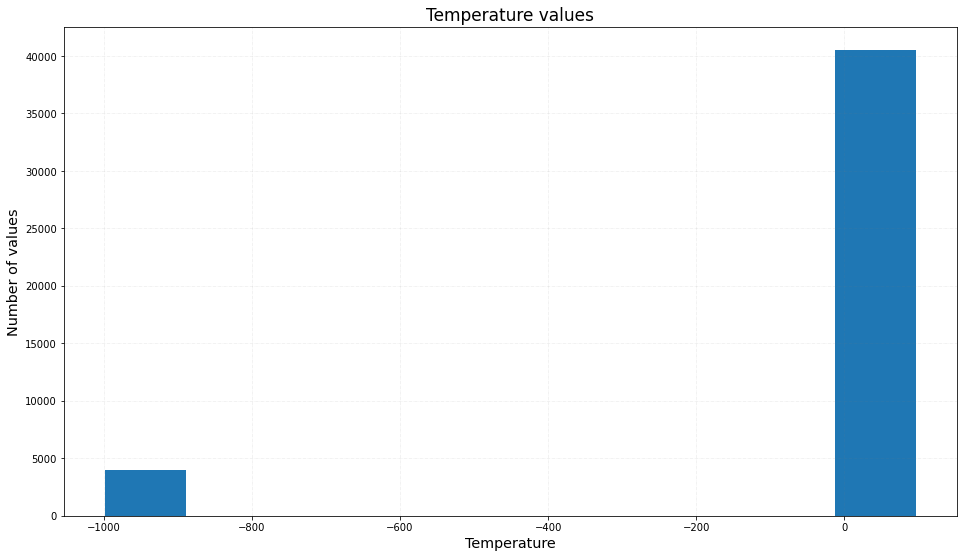

In [34]:
plt.figure(figsize=(16,9))
plt.hist(data['Temperature'])
plt.grid(visible = True, color ='grey',
            linestyle ='-.', linewidth = 0.5,
            alpha = 0.2)
plt.ylabel('Number of values', size='x-large')
plt.xlabel('Temperature', size= 'x-large')
plt.title('Temperature values', fontsize= 17)
plt.show()
plt.close()

It seems there are some outliers that we had not seen yet.\
Let's deal with them. 

In [35]:
np.unique(data['Temperature'].values)

array([-999,    9,   10,   11,   13,   16,   17,   19,   22,   23,   24,
         25,   26,   27,   28,   29,   31,   32,   33,   34,   35,   36,
         37,   38,   39,   40,   41,   42,   43,   44,   45,   46,   47,
         48,   49,   50,   51,   52,   53,   54,   55,   56,   57,   58,
         59,   60,   61,   62,   63,   64,   65,   66,   67,   68,   69,
         70,   71,   72,   73,   74,   75,   76,   77,   78,   79,   80,
         81,   82,   83,   84,   85,   86,   87,   88,   89,   90,   91,
         92,   97])

In [36]:
lim = data[data['Temperature'] == -999].shape[0]
print('There are '+ str(lim) + ' values equal to -999')

There are 3975 values equal to -999


In [37]:
data[(data['Temperature'] == -999) & (data['Injury'] == 1)].shape[0]

7

We realize some temperature values are not realistic: some tempearture are equal to -999. \
To deal with it, we choose to replace -999 with the median of the column.

In [38]:
median = data[data['Temperature'] != -999]['Temperature'].median()
median

62.0

In [39]:
indexes = data[(data['Temperature'] == -999)].index
new_col = np.ones(data.shape[0])
k = 0
for index, row in data.iterrows():
    if index in indexes.values:
        new_col[index] = median
    else:
        new_col[index] = row['Temperature']
data['Temperature'] = new_col

#We also update the copy of the dataset:
data_viz['Temperature'] = data['Temperature']

In [40]:
data[data['Temperature'] == -999].shape

(0, 28)

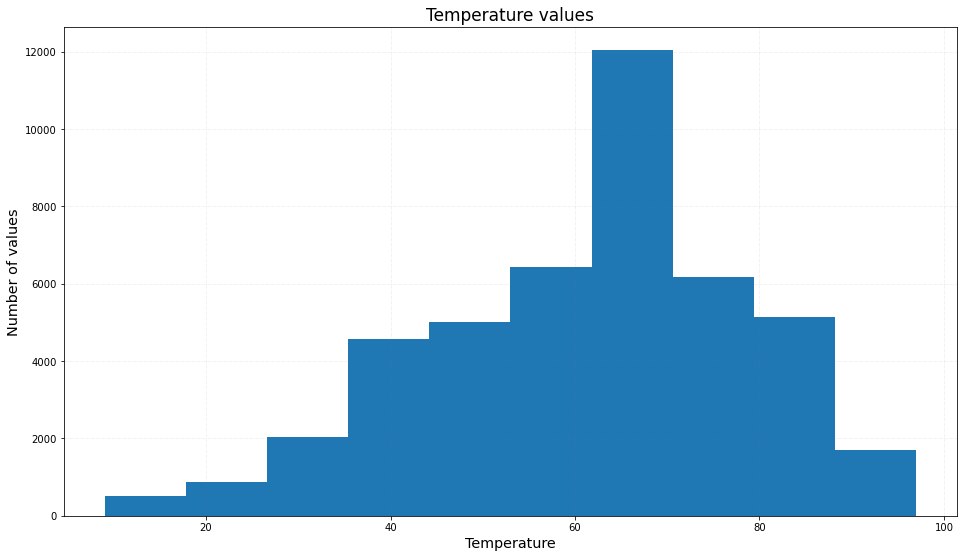

In [41]:
#Temperature

plt.figure(figsize=(16,9))
plt.hist(data['Temperature'])
plt.grid(visible = True, color ='grey',
            linestyle ='-.', linewidth = 0.5,
            alpha = 0.2)
plt.ylabel('Number of values', size='x-large')
plt.xlabel('Temperature', size= 'x-large')
plt.title('Temperature values', fontsize= 17)
plt.show()
plt.close()

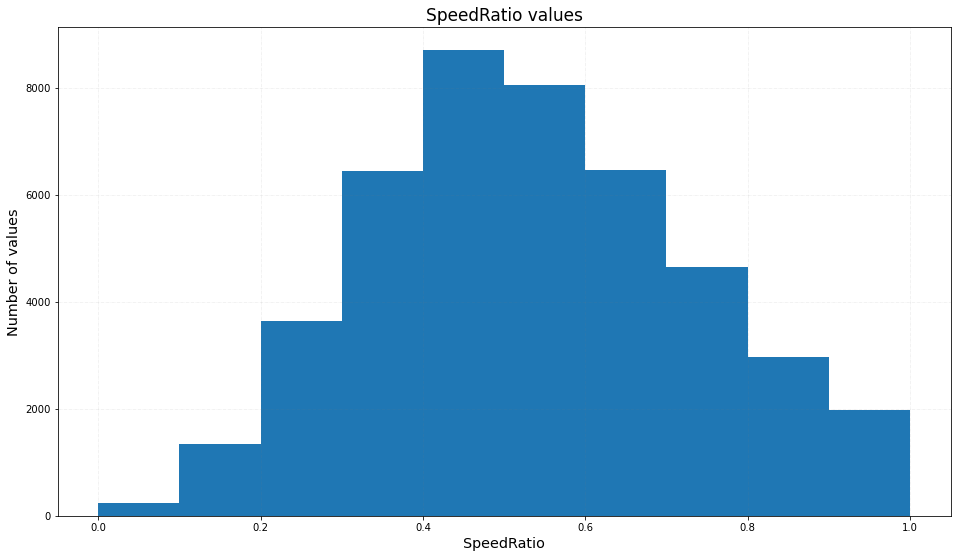

In [42]:
#SpeedRatio
plt.figure(figsize=(16,9))
plt.hist(data['SpeedRatio'])
plt.grid(visible = True, color ='grey',
            linestyle ='-.', linewidth = 0.5,
            alpha = 0.2)
plt.ylabel('Number of values', size='x-large')
plt.xlabel('SpeedRatio', size= 'x-large')
plt.title('SpeedRatio values', fontsize= 17)
plt.show()
plt.close()

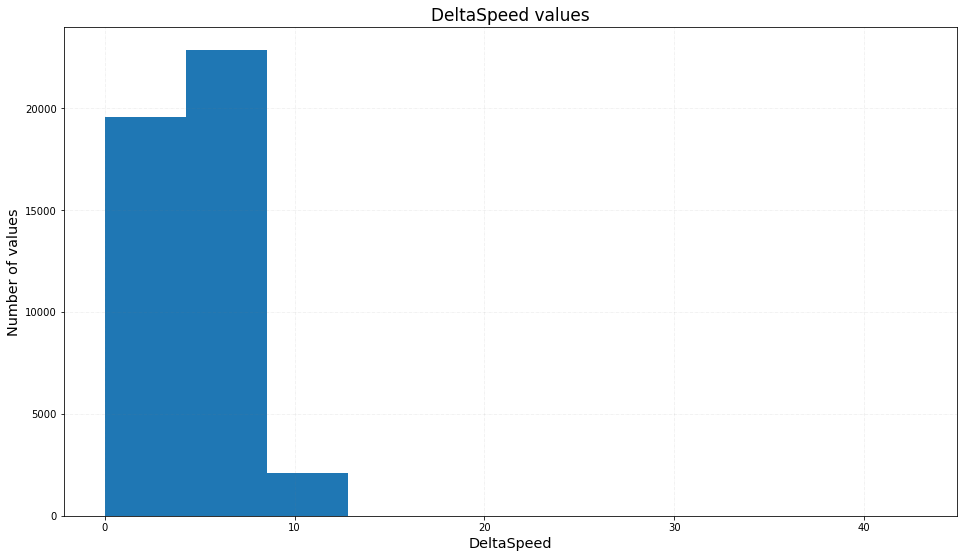

In [43]:
#DeltaSpeed
plt.figure(figsize=(16,9))
plt.hist(data['DeltaSpeed'])
plt.grid(visible = True, color ='grey',
            linestyle ='-.', linewidth = 0.5,
            alpha = 0.2)
plt.ylabel('Number of values', size='x-large')
plt.xlabel('DeltaSpeed', size= 'x-large')
plt.title('DeltaSpeed values', fontsize= 17)
plt.show()
plt.close()

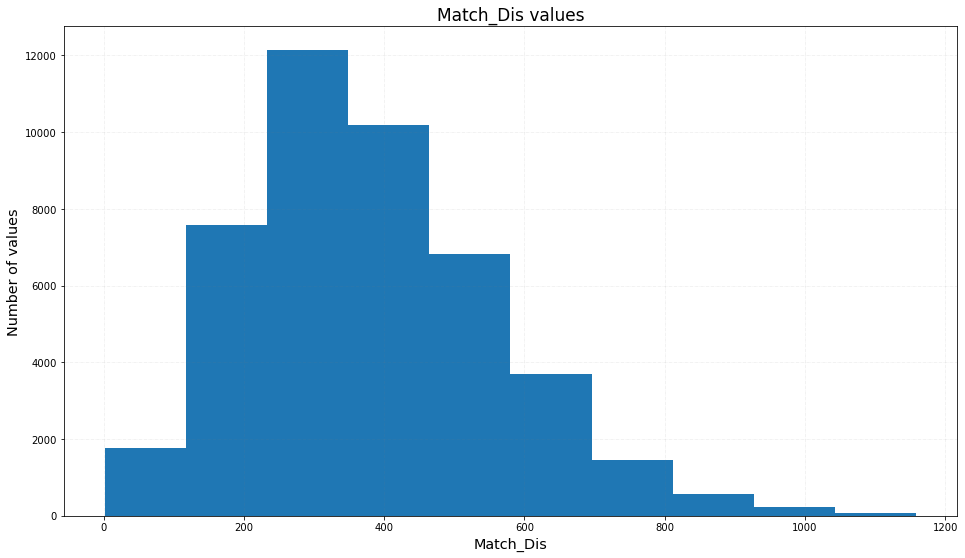

In [47]:
#Match_Dis
plt.figure(figsize=(16,9))
plt.hist(data['Match_Dis'])
plt.grid(visible = True, color ='grey',
            linestyle ='-.', linewidth = 0.5,
            alpha = 0.2)
plt.ylabel('Number of values', size='x-large')
plt.xlabel('Match_Dis', size= 'x-large')
plt.title('Match_Dis values', fontsize= 17)
plt.show()
plt.close()

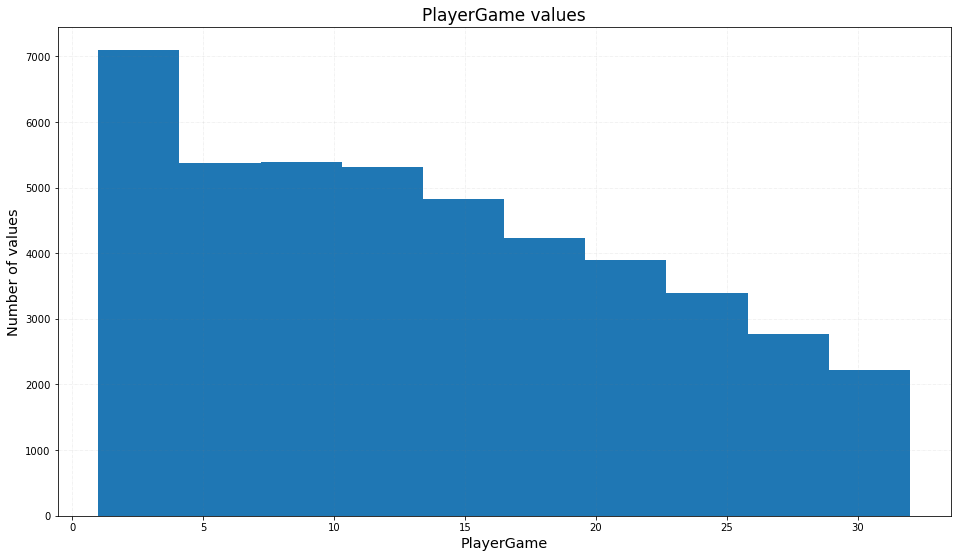

In [48]:
#PlayerGame
plt.figure(figsize=(16,9))
plt.hist(data['PlayerGame'])
plt.grid(visible = True, color ='grey',
            linestyle ='-.', linewidth = 0.5,
            alpha = 0.2)
plt.ylabel('Number of values', size='x-large')
plt.xlabel('PlayerGame', size= 'x-large')
plt.title('PlayerGame values', fontsize= 17)
plt.show()
plt.close()

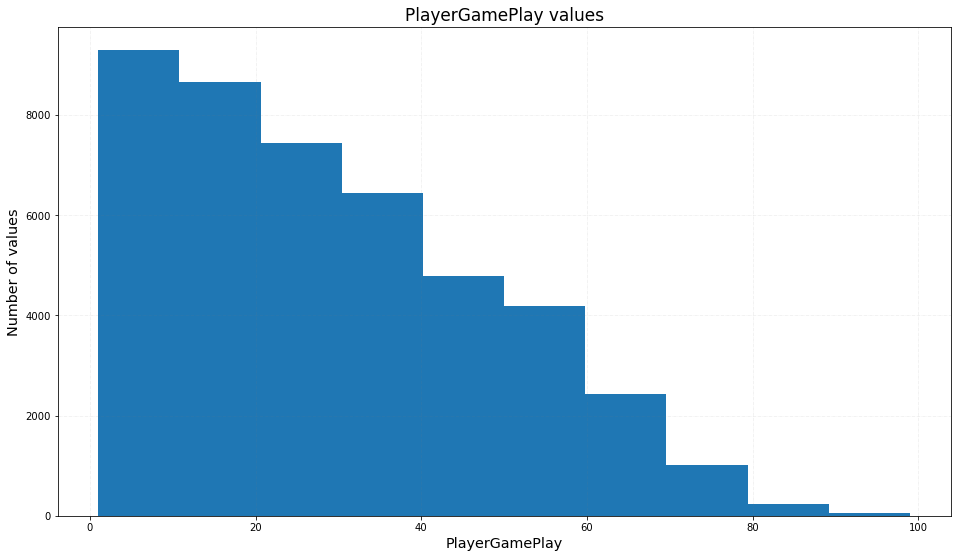

In [49]:
#PlayerGamePlay
plt.figure(figsize=(16,9))
plt.hist(data['PlayerGamePlay'])
plt.grid(visible = True, color ='grey',
            linestyle ='-.', linewidth = 0.5,
            alpha = 0.2)
plt.ylabel('Number of values', size='x-large')
plt.xlabel('PlayerGamePlay', size= 'x-large')
plt.title('PlayerGamePlay values', fontsize= 17)
plt.show()
plt.close()

**These visualization show there is no outliers in the remaining dataset.**

#### 1.4.b Unrealistic distribution of positions <a class="anchor" id="sub_section_1_4_b"></a>

*Position*

We want to check if the distribution of positions in our dataset is similar to the reality (we compare with the composition during a match, which is contained is the variable real_position )

![Image](https://upload.wikimedia.org/wikipedia/commons/thumb/b/be/Positions_American_Football.svg/1200px-Positions_American_Football.svg.png)
Source: *Wikipedia*

In [50]:
real_positions = ["Offensive Lineman","Offensive Lineman","Offensive Lineman","Offensive Lineman",
                  "Offensive Lineman","Linebacker","Linebacker","Linebacker","Wide Receiver",
                  "Wide Receiver","Safety","Safety","Defensive Lineman","Defensive Lineman","Defensive Lineman",
                  "Defensive Lineman","Cornerback","Cornerback","Running Back","Running Back","Tight End",
                  "Quarterback","Kicker"]
data_positions = data_viz['Position']



Real distribution of positions during a match :

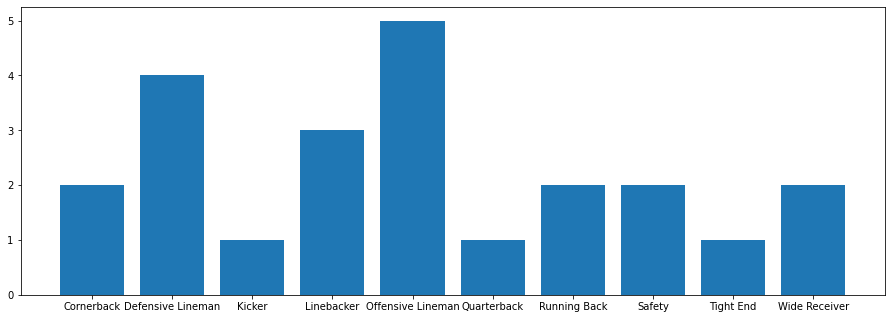

In [51]:
fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
positions = np.unique(real_positions)
count = []
for pos in positions:
    count.append(real_positions.count(pos))
ax.bar(positions,count)
plt.show()

Distribution of position we have in the dataset :

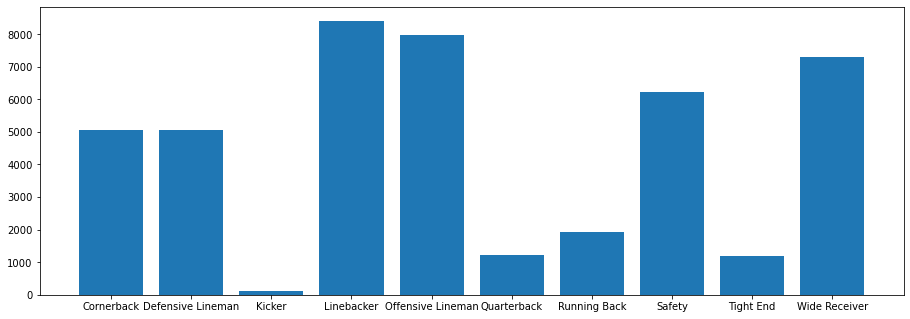

In [52]:
fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
dpositions = np.unique(data_positions)
dcount = []
for pos in dpositions:
    dcount.append(np.count_nonzero([data_positions==pos]))
ax.bar(dpositions,dcount)
plt.show()

#### 1.4.c Correlation between features <a class="anchor" id="sub_section_1_4_c"></a>

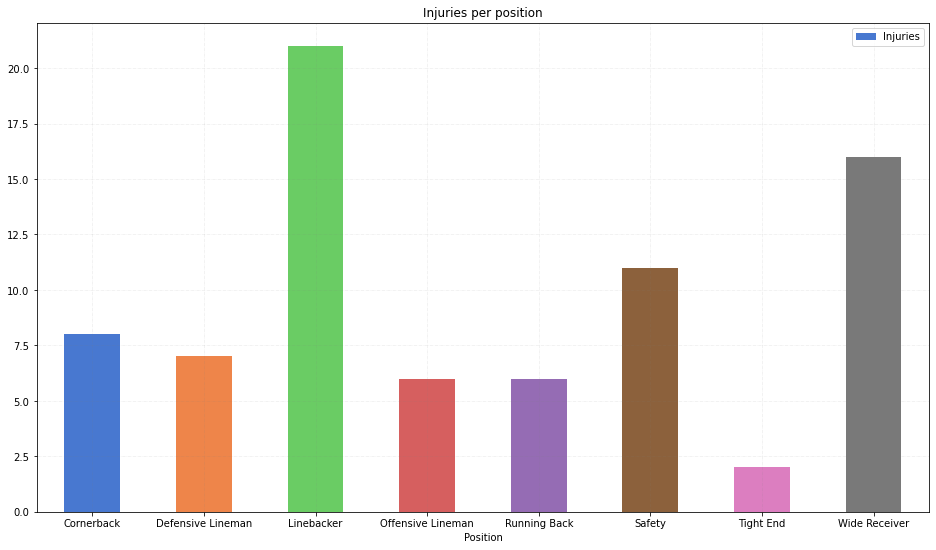

In [53]:
query="SELECT COUNT(IR.PlayKey) AS Injuries, PL.RosterPosition AS Position FROM InjuryRecord AS IR JOIN PlayList AS PL ON PL.PlayKey = IR.PlayKey GROUP BY PL.RosterPosition"
injury_per_pos = ps.pysqldf(query)
ax = injury_per_pos.plot.bar(x='Position',y='Injuries', figsize =(16, 9), color=sns.color_palette('muted'), rot =0,
                            title = 'Injuries per position')
ax.grid(visible = True, color ='grey',
            linestyle ='-.', linewidth = 0.5,
            alpha = 0.2)

In [54]:
data[data['injured_before']==1].shape[0]

0

We can drop the column _injured_before_ since it does not contain any useful information.

In [55]:
to_drop = ["injured_before"]
data.drop(to_drop, axis=1, inplace=True)

Finally, we compute the heatmap (correlation matrix) of our dataset. We only concider the non-categorical variables.

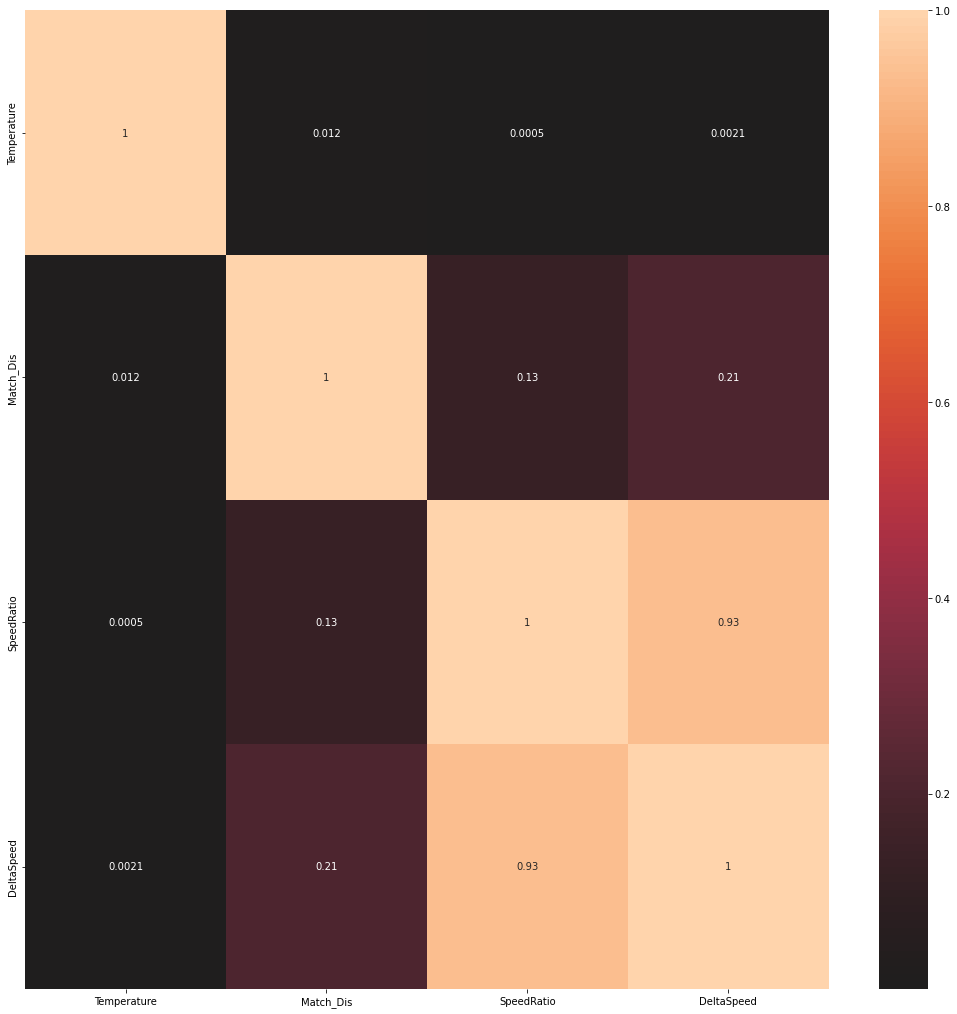

In [56]:
plt.figure(figsize=(18,18))
sns.heatmap(data.select_dtypes(include=['float']).corr(),annot=True,center = 0)
plt.show()

***
## 2. Naive approach : ML without dealing with class imbalance <a class="anchor" id="chapter2"></a>

We just consider applying a Machine Learning model on our dataset.
Our goal is to do classification: let's build a model that predicts if a given 'play' will lead to an injury or not.

In this first approach, we will not try to handle the fact that our dataset is very (very) imbalanced by resampling it.

We have to select a model. Some useful criteria to make the choice: \
    - it is a classification problem;\
    - it is a very large dataset (more than 200k rows);\
    - the dataset is imbalanced;\
    - the dataset might be sequential (at least because of a dependency to time between plays).
    
First and foremost, let's consider two models that may have good results with these constraints.    

### 2.1 Pre-processing  <a class="anchor" id="section2_1"></a>

#### 2.1.a Useful pre-processing <a class="anchor" id="sub_section_2_1_a"></a>

In [65]:
#Normalization

#the function
def normalize(data: pd.Series):
    max = data.max(skipna = True)
    min = data.min(skipna = True)
    dname = data.name
    A = []
    for i in data:
        A.append((i-min)/(max-min))
    norm_data = pd.Series(A, name=dname)
    return norm_data

#applying the function
to_normalize = ['PlayerGame','Temperature','PlayerGamePlay', 'DeltaSpeed' , 'Match_Dis']
for column in to_normalize :
    data[column] = normalize(data[column])

#### 2.1.b Train test split <a class="anchor" id="sub_section_2_1_b"></a>

We divide our dataset into two subsets: 
* 70% of the DataSet will be used for training our algorithms,
* 30% of the DataSet will be used for testing. <br>

We also identify the feature that is our target class:  `Injury`.

_(The percentages are arbitrarily chosen based on the best practises)_

Since we have a relatively small sample of plays with injuries, we choose to deal with Injury rows and non-Injury rows separately, then we aggregate both outputs.

In [66]:
#Then we prepare our vector of features and a vector with our target feature
to_drop = ["Injury"]


data_injury = data[data['Injury'] == 1]
data_non_injury = data[data['Injury'] == 0]

X_injury = data_injury.copy()
X_injury.drop(to_drop, axis=1,inplace=True)
y_injury = data_injury['Injury']

X_train_injury, X_test_injury, y_train_injury, y_test_injury = train_test_split(X_injury, y_injury, test_size=0.3)

X_non_injury = data_non_injury.copy()
X_non_injury.drop(to_drop, axis=1,inplace=True)
y_non_injury = data_non_injury['Injury']

X_train_non_injury, X_test_non_injury, y_train_non_injury, y_test_non_injury = train_test_split(X_non_injury, y_non_injury, test_size=0.3)

#Now we aggrgate both datasets and we shuffle them

X_train = pd.concat([X_train_injury, X_train_non_injury]).sample(frac=1).reset_index(drop=True)
X_test = pd.concat([X_test_injury, X_test_non_injury]).sample(frac=1).reset_index(drop=True)
y_train = pd.concat([y_train_injury, y_train_non_injury]).sample(frac=1).reset_index(drop=True)
y_test = pd.concat([y_test_injury, y_test_non_injury]).sample(frac=1).reset_index(drop=True)


### 2.2 First Classification Method : KNN-Method <a class="anchor" id="section2_2"></a>

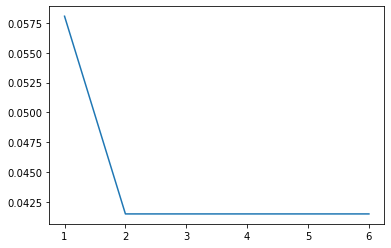

In [67]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error #4674

ks = []
rmses = []
for k in range(1,7, 1):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)
    train_preds = knn_model.predict(X_test)
    mse = mean_squared_error(y_test, train_preds*1)
    rmse = np.sqrt(mse)
    ks.append(k)
    rmses.append(rmse)
    
plt.plot(ks, rmses)

Apparently, starting from k = 2, the RMSE does not go down anymore. We will try KNN with k=2

In [70]:
knn_model = KNeighborsClassifier(n_neighbors=2)
knn_model.fit(X_train, y_train)
train_preds = knn_model.predict(X_test)
mse = mean_squared_error(y_test, train_preds*1)
rmse = np.sqrt(mse)
print("RMSE  = " + str(rmse))

RMSE  = 0.04150563093660587


Discuss 2-NN results

### 2.3 Second Classification Method :  Decision Tree <a class="anchor" id="section2_2"></a>

We first start with a decision tree. It is an efficient model for classification (even if very often it is not the most performing one), and above all it is quite easily interpretable.

#### 2.3.a Implementing Decision Tree  <a class="anchor" id="sub_section_2_3_a"></a> 
<br>

In [71]:
start_time = time.time()

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_preds = dt.predict(X_test)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.12995672225952148 seconds ---


The time is took to compute a single decision tree is reasonable. Thus, we can try to tune some hyperparameters.

The hyperparameters we will try to optimize are the follwing ones: 
- max_depth
- min_samples_split
- min_samples_leaf
- max_features
- class_weight

We made this choice according to the relevance of each one, which is mentionned in this article (https://www.jeremyjordan.me/hyperparameter-tuning/) and this one (Rafael Gomes Mantovani, Tomáš Horváth, Ricardo Cerri, Sylvio Barbon Junior, Joaquin Vanschoren, André Carlos Ponce de Leon Ferreira de Carvalho, _“An empirical study on hyperparameter tuning of decision trees”_, arXiv:1812.02207).
Based on these articles, we select some values to test for each one.

The latter is very interesting since it can be a first way to tackle the fact that our dataset is rather imbalanced.

In [72]:
max_depth = [None , 3 , 5 , 10 , 15]

In [73]:
min_samples_split = [2 , 3 , 5 ,10 , 15 , 20 , 30 , 40]

In [74]:
min_samples_leaf = [1 , 2 , 3 , 5 , 10 , 15 , 20]

In [75]:
max_features = [0.5 , 0.33 , 0.75 , 0.25 , 'sqrt' , 'log2' , None]

In [76]:
#We will assign different weights to the Injury class
class_weight =  [{0: 1, 1: 2} , {0: 1, 1: 5} , {0: 1, 1: 10} , {0: 1, 1: 20} , {0: 1, 1: 40}]

In [77]:
random_grid = {'max_depth': max_depth,

               'min_samples_split': min_samples_split,

               'min_samples_leaf': min_samples_leaf,
               
               'max_features': max_features,

               'class_weight': class_weight}

In [78]:
start_time = time.time()

dt = DecisionTreeClassifier()
dt_random = RandomizedSearchCV(estimator = dt, param_distributions = random_grid, scoring = "recall" , random_state = 42)
# we use recall, see explanation in the Evaluation part
dt_random.fit(X_train, y_train)
parameters = dt_random.best_params_

print(parameters)

dt_preds = dt_random.predict(X_test)

print("--- %s seconds ---" % (time.time() - start_time))

{'min_samples_split': 30, 'min_samples_leaf': 15, 'max_features': 0.25, 'max_depth': 10, 'class_weight': {0: 1, 1: 20}}
--- 1.5613441467285156 seconds ---


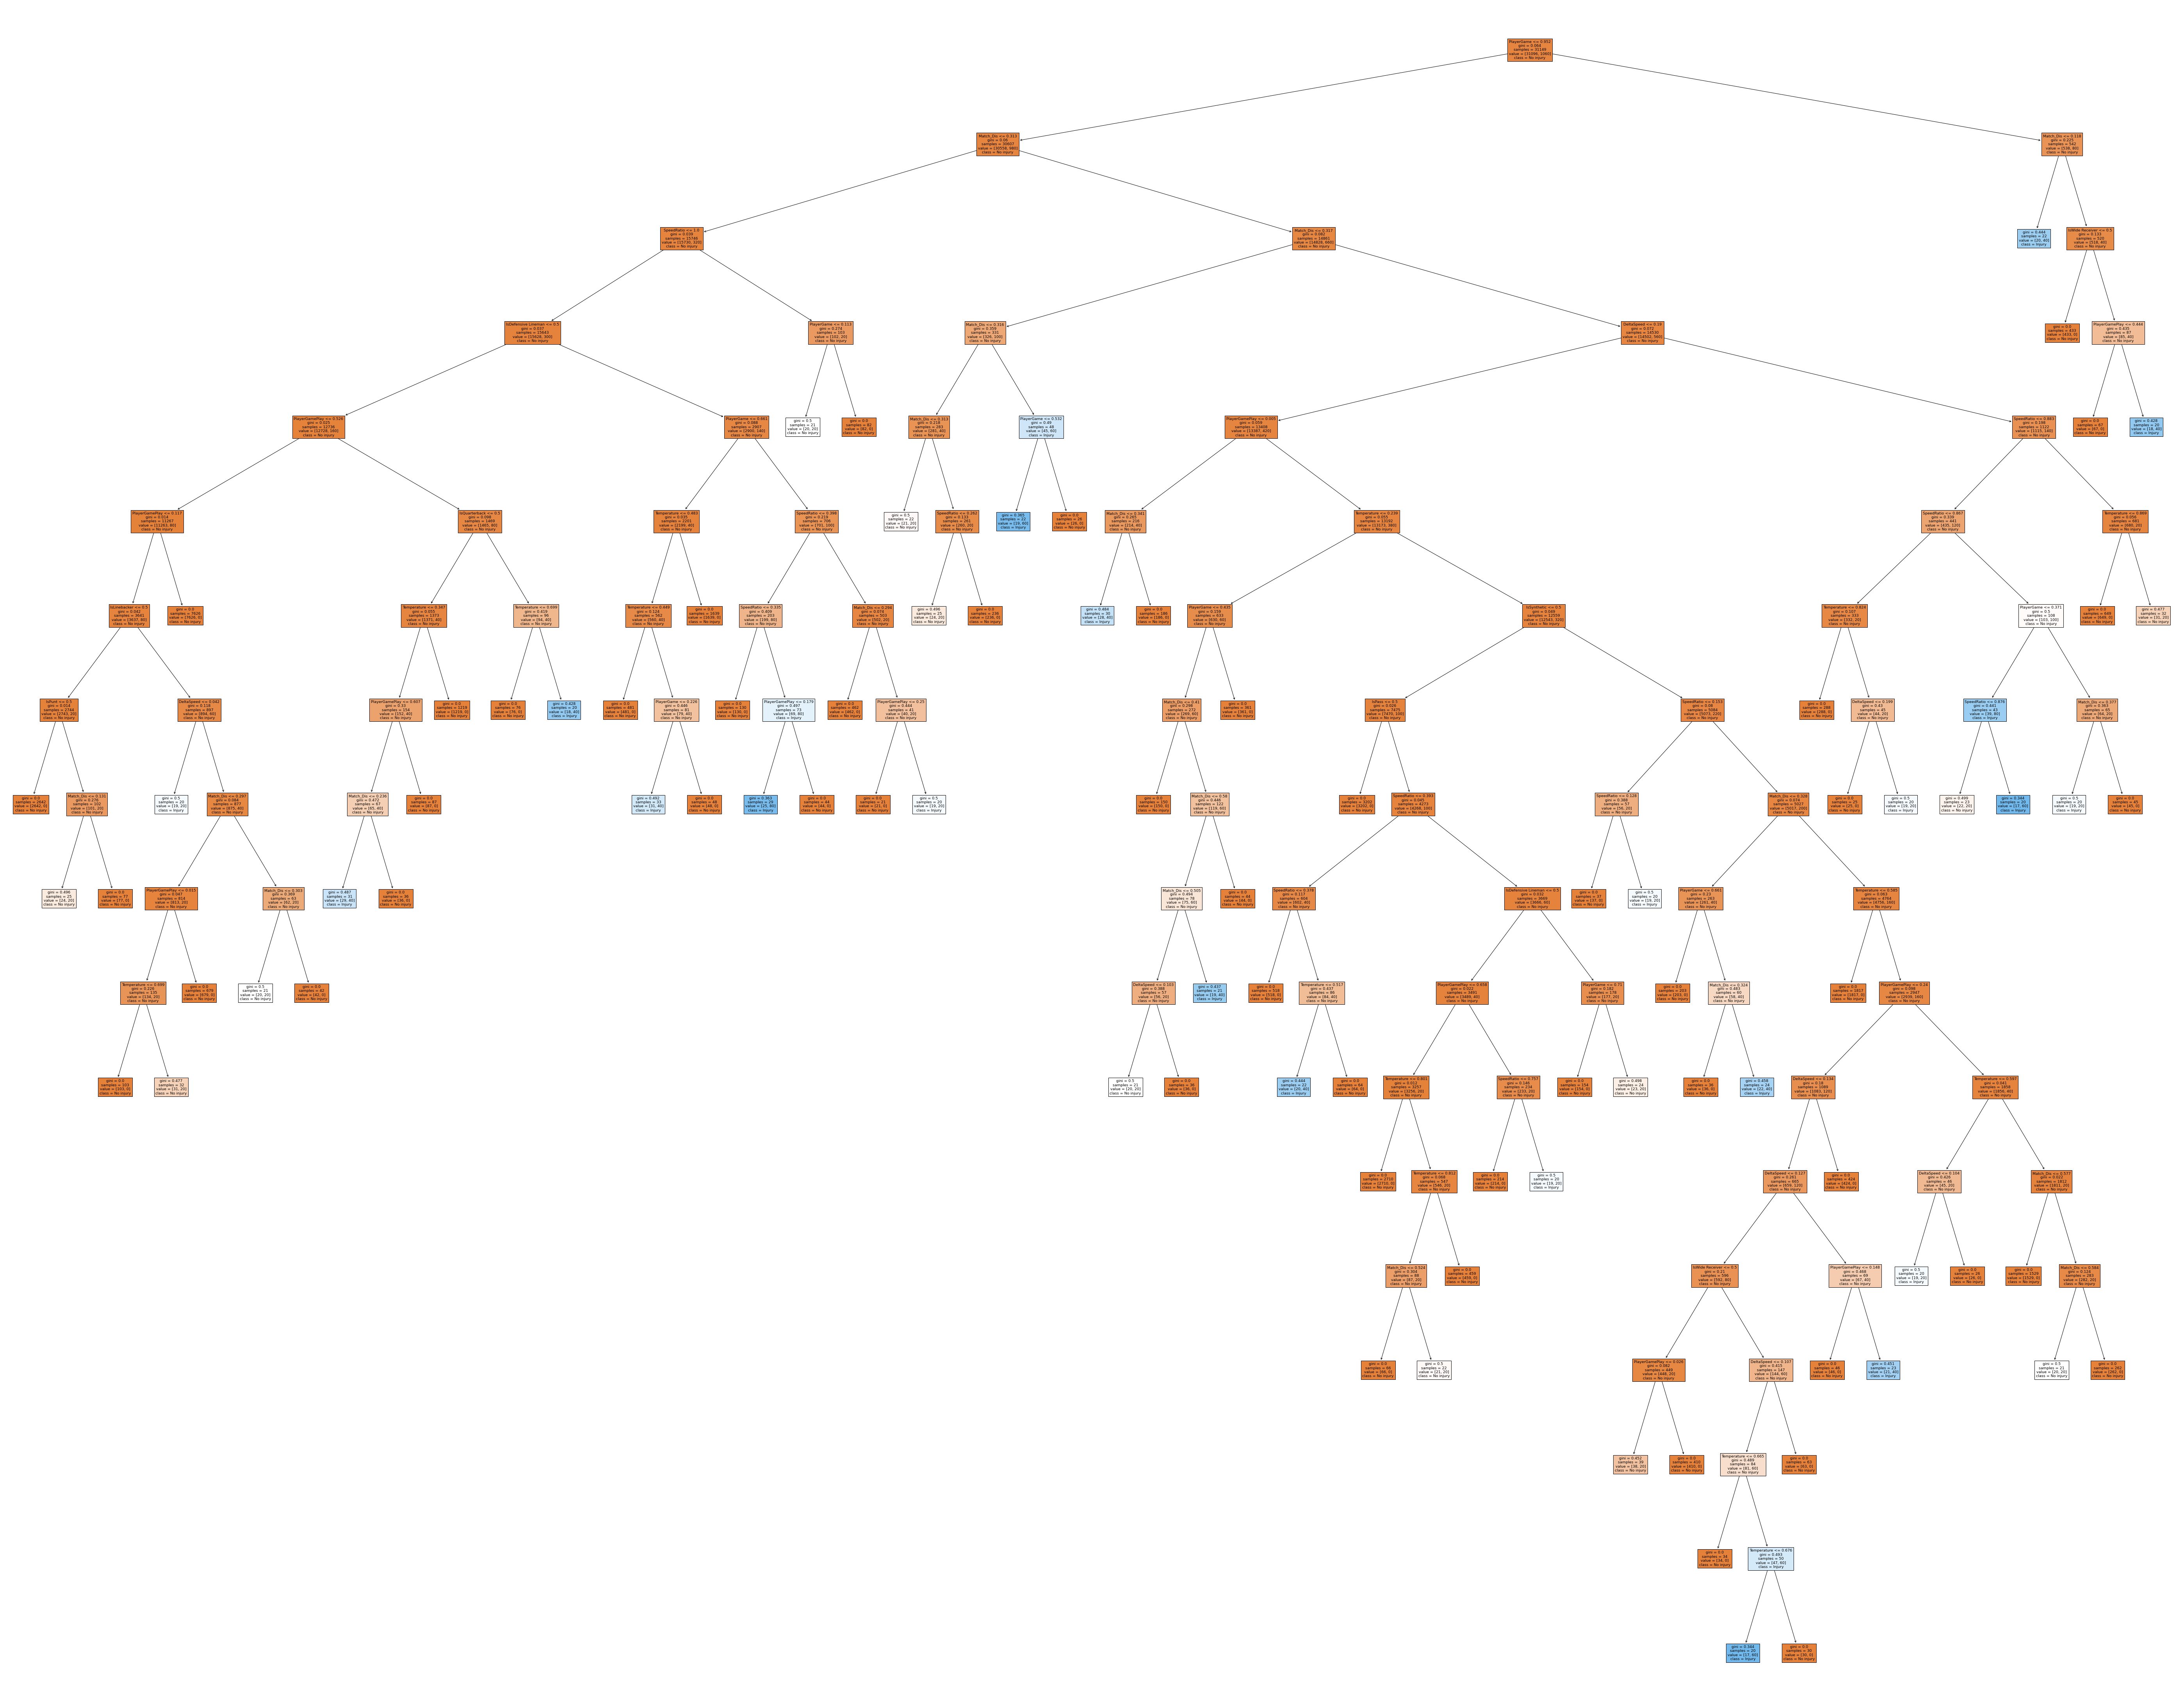

In [79]:
#We now plot the result

dt = DecisionTreeClassifier(min_samples_split = 3, min_samples_leaf = 20, max_features =None, max_depth = None, class_weight = {0: 1, 1: 20})
dt.fit(X_train, y_train)
clf = dt.fit(X_train, y_train)
dt = dt_random.predict(X_test)


fig = plt.figure(figsize=(100,80))
_ = tree.plot_tree(clf, 
                   feature_names=X_train.columns.values,  
                   class_names=['No injury' , 'Injury'],
                   filled=True)

#### 2.3.b Evaluation Decision Tree  <a class="anchor" id="sub_section_2_3_b"></a>

The F1-score is a classification metric that measures the ability of a model to predict positive individuals well, both in terms of accuracy (rate of correct positive predictions) and recall (rate of correctly predicted positives). 

In [80]:
from sklearn.metrics import f1_score, roc_curve
f1_score(np.array(y_test), np.array(dt_preds), average="micro")

0.9888397872818515

Instead of the F1-score, we can use another metric. \
Above all, we want to know if we had good prediction for injuries. The rest is less important. That is why we choose recall.

![Image](https://miro.medium.com/max/836/1*dXkDleGhA-jjZmZ1BlYKXg.png)

In [81]:
from sklearn.metrics import recall_score
recall_score(np.array(y_test), np.array(dt_preds))

0.0

Now we have a good measure of how our model works for predicting positive cases, i.e. injuries. Here, it tells us the result is pretty bad...

#### 2.3.c Evaluation with Confusion matrix  <a class="anchor" id="sub_section_2_3_c"></a>

We want to evaluate more accurately our model, and identify where the error are made. \
In particular, we need to know if most of the errors we made relate to undetected 'positive' plays.

In [82]:
cm = confusion_matrix(y_test, dt_preds)
cm

array([[13202,   126],
       [   23,     0]])

This is clearly not a good result: no correct prediction on injuries.

### 2.4 Third Classification Method : Random Forest <a class="anchor" id="section2_4"></a>

We will apply the same methodolgy for an ensemble method known for its efficency for classification: Random Forest

#### 2.4.a Implementing Random Forest  <a class="anchor" id="sub_section_2_4_a"></a>

In [83]:
from sklearn.ensemble import RandomForestClassifier
start_time = time.time()

rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.766639232635498 seconds ---


In [84]:
n_estimators = [50,100,200]

For the other parameters, we test the same as previously (for a single Decision Tree)

In [85]:
random_grid_rf = {'max_depth': max_depth,
                  'min_samples_split': min_samples_split,
                  'min_samples_leaf': min_samples_leaf,
                  'max_features': max_features,
                  'class_weight': class_weight,
                  'n_estimators': n_estimators
                 }

In [86]:
start_time = time.time()

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid_rf, scoring = "recall" , random_state = 42)
# we use recall, see explanation in the Evaluation part
rf_random.fit(X_train, y_train)
parameters = rf_random.best_params_

print(parameters)

rf_preds = rf_random.predict(X_test)

print("--- %s seconds ---" % (time.time() - start_time))

{'n_estimators': 200, 'min_samples_split': 15, 'min_samples_leaf': 15, 'max_features': 0.5, 'max_depth': None, 'class_weight': {0: 1, 1: 40}}
--- 150.34839296340942 seconds ---


It seems again feasible to test some combinations of hyperparameters and optimize our Random Forest model.

#### 2.4.b Evaluation Random Forest  <a class="anchor" id="sub_section_2_4_b"></a>
We start by computing the recall, to see how our model as performed for finding injuries.

In [87]:
recall_score(np.array(y_test), np.array(rf_preds))

0.0

#### 2.4.c Evaluation with Confusion matrix  <a class="anchor" id="sub_section_2_4_c"></a>

In [88]:
cm = confusion_matrix(y_test, rf_preds)
cm

array([[13328,     0],
       [   23,     0]])

Apparently, the result is not better.

Thus, we need to design a better model. We think it will be possible to achieve our goal by "correcting" the main problem with our dataset: class imbalance.

In [89]:
cm = confusion_matrix(y_test, train_preds)
cm

array([[13328,     0],
       [   23,     0]])

***
## 3. ML with dealing with class imbalance  <a class="anchor" id="chapter3"></a>

### 3.1 Dealing with class imbalance <a class="anchor" id="section3_1"></a>

Let's check the current (imbalanced) class distribution

In [90]:
# summarize class distribution
counter = data[data['Injury'] == 1].shape[0]
percent = 100*counter/data.shape[0]
print('We have ',counter,' plays leading to injuries in the dataset, which is ' , percent , '% of our dataset')

We have  76  plays leading to injuries in the dataset, which is  0.1707865168539326 % of our dataset


The challenge of working with imbalanced datasets is that most machine learning techniques will ignore, and in turn have poor performance on, the minority class, although typically it is performance on the minority class that is most important.

One approach to addressing imbalanced datasets is to oversample the minority class. We will try to deal with our balance problem implementing a technique called SMOTE, or Synthetic Minority Oversampling Technique.

SMOTE works by selecting examples in the low-represented class that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

A general downside of the approach is that synthetic examples are created without considering the majority class, possibly resulting in ambiguous examples if there is a strong overlap for the classes, which might be the case in our analysis.

We will only apply SMOTE on the train data, as we want to do our predictions on "real" injuries.

In [91]:
# transform the dataset
oversample = imblearn.over_sampling.SMOTE(sampling_strategy=0.05) #we will oversample our dataset so that we have a 95% - 5% ratio
#it is still better than 
X_train_os, y_train_os = oversample.fit_resample(X_train, y_train)

In [92]:
# summarize the new class distribution
sum((y_train_os == 1)*1)

1554

### 3.2 First Classification Method : Decision Tree <a class="anchor" id="section3_2"></a>
We retry the previous model with the oversampled dataset.

In [93]:
start_time = time.time()

dt_os = DecisionTreeClassifier()
dt_random_os = RandomizedSearchCV(estimator = dt_os, param_distributions = random_grid, scoring = "recall" , random_state = 42)
# we use recall, see explanation in the Evaluation part
dt_random_os.fit(X_train_os, y_train_os)
parameters = dt_random_os.best_params_

print(parameters)

dt_preds_os = dt_random_os.predict(X_test)

print("--- %s seconds ---" % (time.time() - start_time))

{'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': 0.33, 'max_depth': 3, 'class_weight': {0: 1, 1: 40}}
--- 1.7274439334869385 seconds ---


Then we evaluate this new model

In [94]:
#Recall
recall_score(np.array(y_test), np.array(dt_preds_os))

0.5217391304347826

It is a better result: we have now correct predictions!

In [95]:
#Confusion matrix
cm = confusion_matrix(y_test, dt_preds_os)
cm

array([[4841, 8487],
       [  11,   12]])

Let's remind what the confusion matrix coefficient means:
![Image](http://rasbt.github.io/mlxtend/user_guide/evaluate/confusion_matrix_files/confusion_matrix_1.png)

We have a lot of false negative : maybe the DT has maximized the number of True Negatives, but this result is not very interesting since it has no practical application: the model can't tell the coach a player is likely to be injured at almost each action.

This bad result might come from the fact that we correct the class imbalance twice: with the SMOTE but also in the Grid Search (by optimizing Class Weight). Let's try without the second one:

In [96]:
random_grid_os = {'max_depth': max_depth,

               'min_samples_split': min_samples_split,

               'min_samples_leaf': min_samples_leaf,
               
               'max_features': max_features}

In [97]:
start_time = time.time()

dt_os = DecisionTreeClassifier()
dt_random_os = RandomizedSearchCV(estimator = dt_os, param_distributions = random_grid_os, scoring = "recall" , random_state = 42)
# we use recall, see explanation in the Evaluation part
dt_random_os.fit(X_train_os, y_train_os)
parameters = dt_random_os.best_params_

print(parameters)

dt_preds_os = dt_random_os.predict(X_test)

print("--- %s seconds ---" % (time.time() - start_time))

{'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 0.75, 'max_depth': None}
--- 2.155207872390747 seconds ---


In [98]:
#Recall
recall_score(np.array(y_test), np.array(dt_preds_os))

0.0

In [99]:
#Confusion matrix
cm = confusion_matrix(y_test, dt_preds_os)
cm

array([[13203,   125],
       [   23,     0]])

We have corrected the previous problem, but this time we have less True Negatives. \
It is hard to use this model to do accurate predictions on injuries, but by understanding which variables plays an important role in the Decision Tree, we will still get some relevant insight on the causes of players injuries.

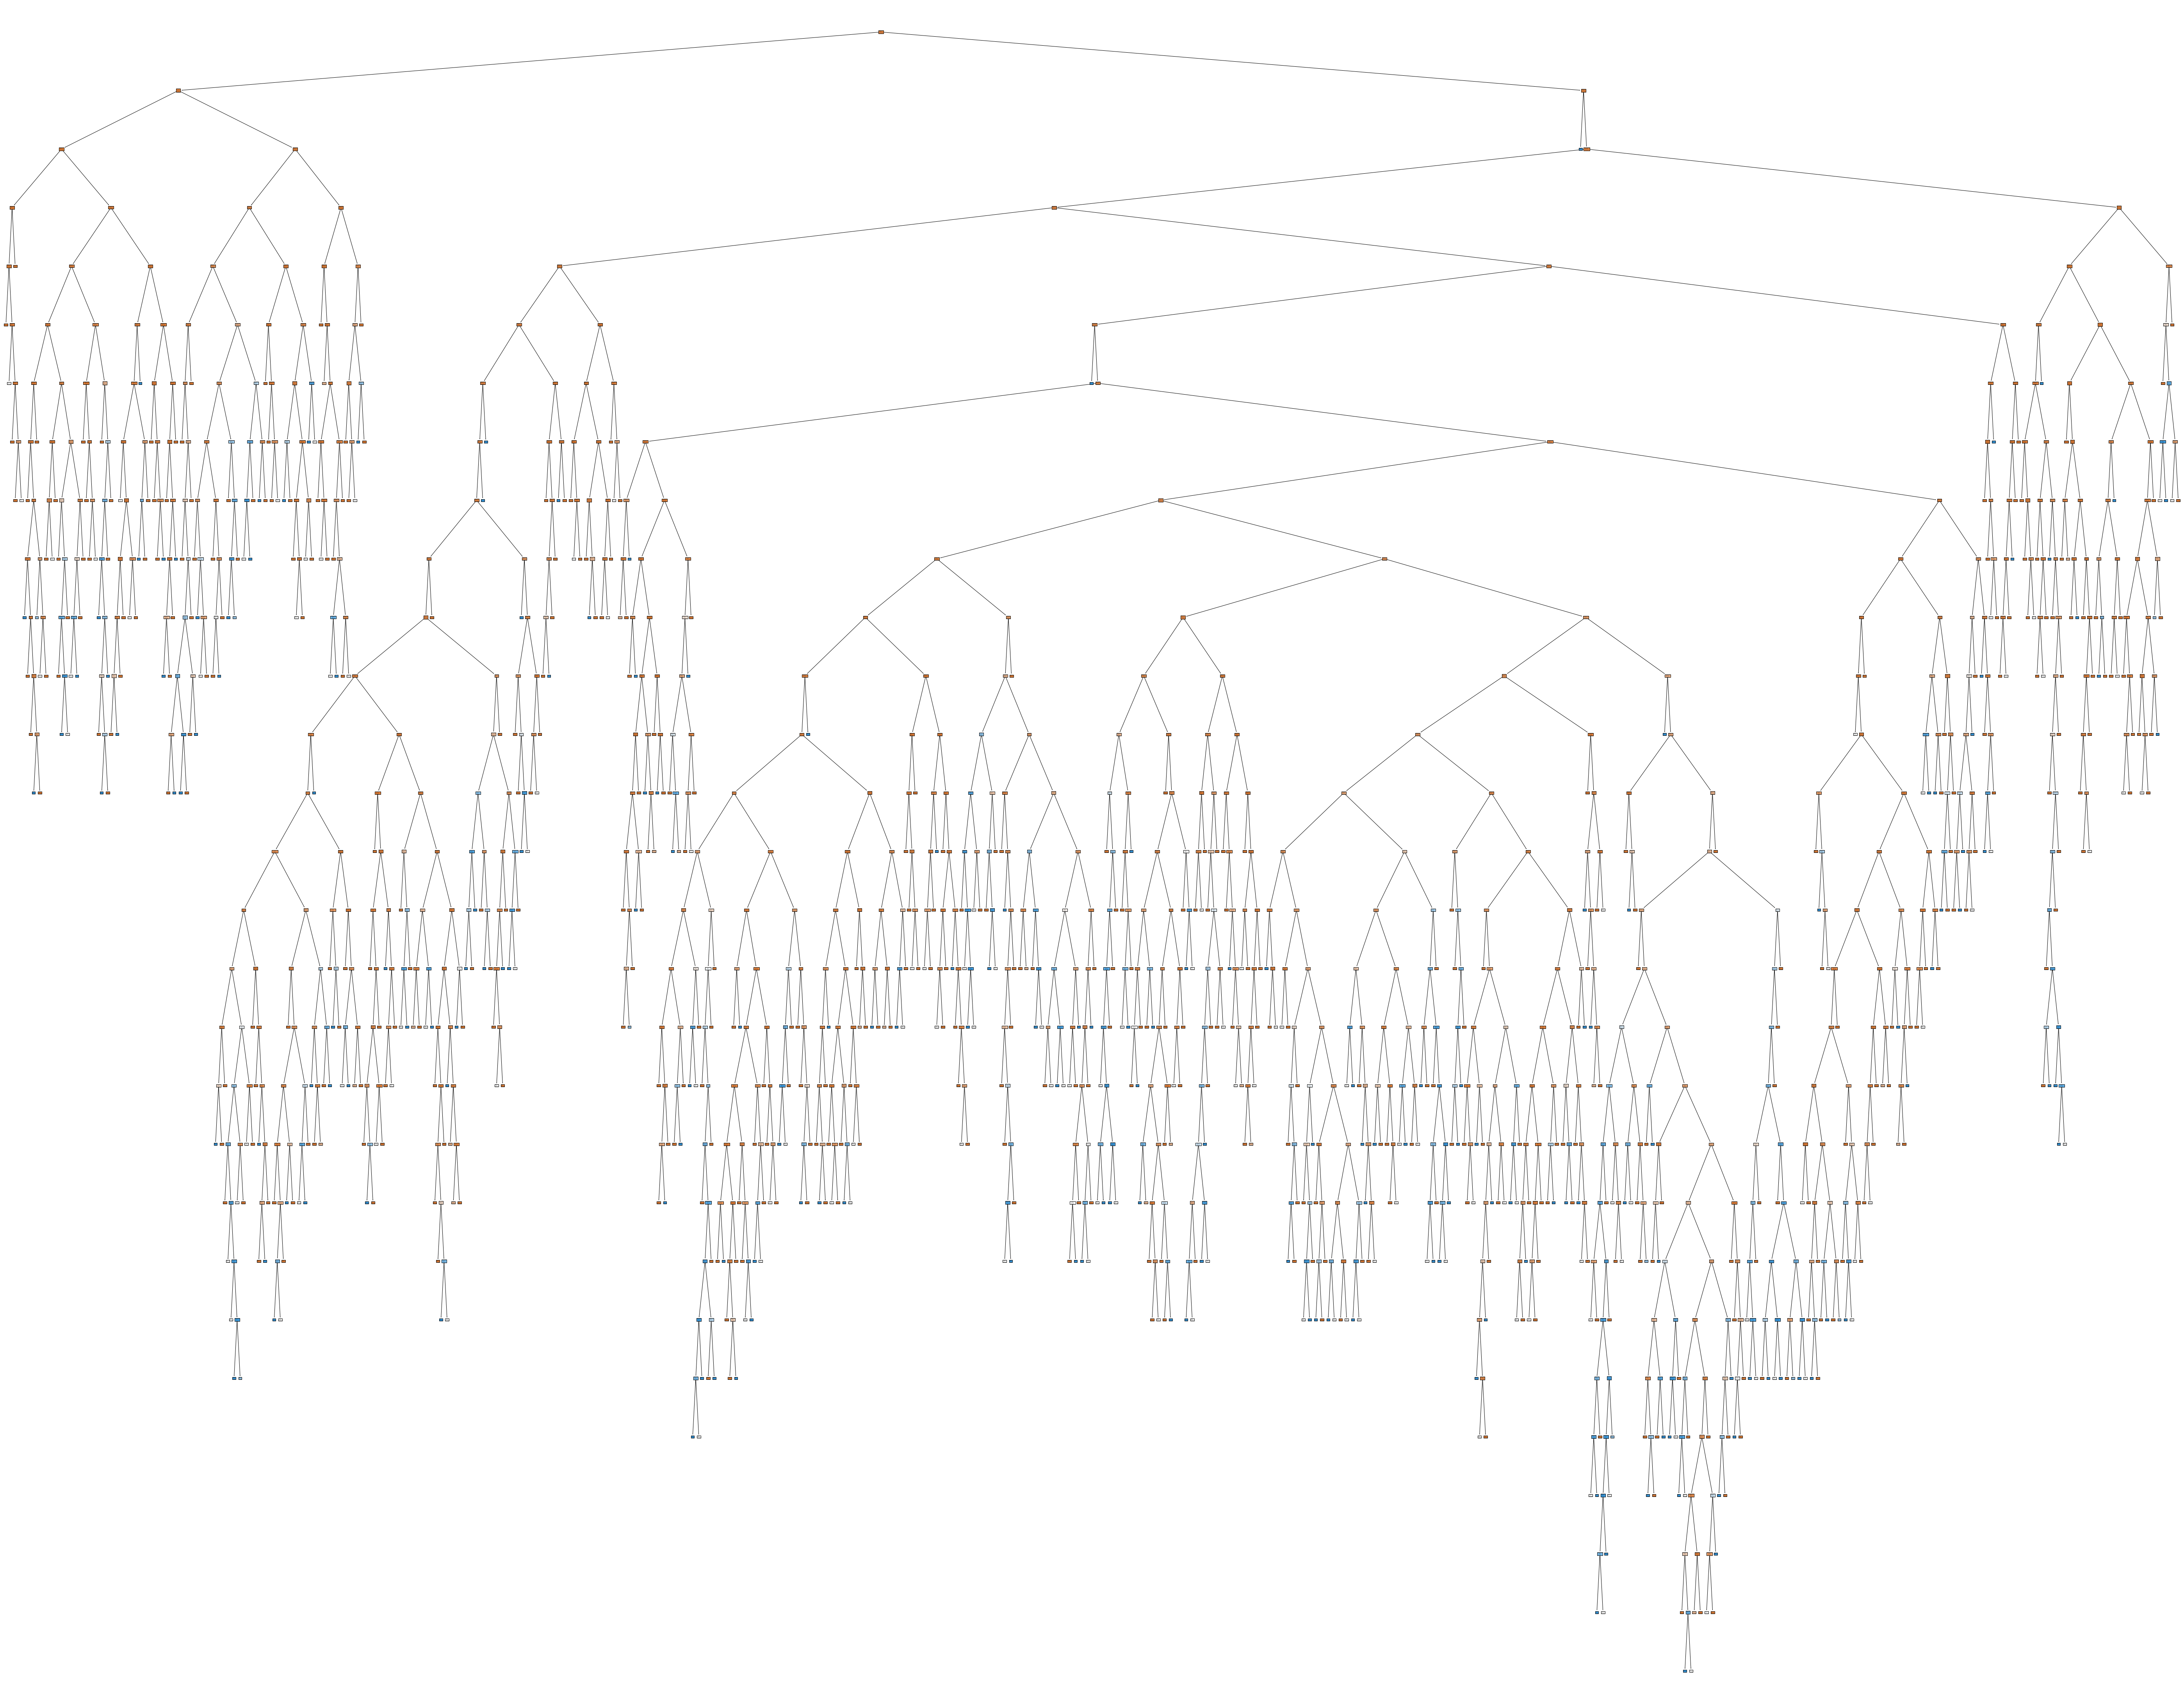

In [100]:
#We now plot the result

dt_os = DecisionTreeClassifier(min_samples_split = 3, min_samples_leaf = 2, max_features =0.75, max_depth = None)
dt_os.fit(X_train_os, y_train_os)
clf = dt_os.fit(X_train_os, y_train_os)
dt_os = dt_os.predict(X_test)


fig = plt.figure(figsize=(100,80))
_ = tree.plot_tree(clf, 
                   feature_names=X_train_os.columns.values,  
                   class_names=['No injury' , 'Injury'],
                   filled=True)

Unfortunately, the DT is very complex, and thus not easily interpretable.

Instead of visualizing the tree, it would be great to print the features' importance, which is possible with a Random Forest.

### 3.3 Second Classification Method : Random Forest <a class="anchor" id="section3_3"></a>

Same procedure as before...

In [101]:
#We immediately get rid of the class imbalance correction in the Grid Search
random_grid_rf_os = {'max_depth': max_depth,
                  'min_samples_split': min_samples_split,
                  'min_samples_leaf': min_samples_leaf,
                  'max_features': max_features,
                  'n_estimators': n_estimators
                 }

In [102]:
start_time = time.time()

rf_os = RandomForestClassifier()
rf_random_os = RandomizedSearchCV(estimator = rf_os, param_distributions = random_grid_rf_os, scoring = "recall" , random_state = 42)
# we use recall, see explanation in the Evaluation part
rf_random_os.fit(X_train_os, y_train_os)
parameters = rf_random_os.best_params_

print(parameters)

rf_preds_os = rf_random_os.predict(X_test)

print("--- %s seconds ---" % (time.time() - start_time))

{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 15, 'max_features': 0.75, 'max_depth': None}
--- 197.86704778671265 seconds ---


In [103]:
#Recall
recall_score(np.array(y_test), np.array(rf_preds_os))

0.0

In [104]:
#Confusion matrix
cm = confusion_matrix(y_test, rf_preds_os)
cm

array([[13309,    19],
       [   23,     0]])

Not any good predictions... Maybe it will be better with the double correction of class imbalance.

In [105]:
start_time = time.time()

rf_os = RandomForestClassifier()
rf_random_os = RandomizedSearchCV(estimator = rf_os, param_distributions = random_grid_rf, scoring = "recall" , random_state = 42)
# we use recall, see explanation in the Evaluation part
rf_random_os.fit(X_train_os, y_train_os)
parameters = rf_random_os.best_params_

print(parameters)

rf_preds_os = rf_random_os.predict(X_test)

print("--- %s seconds ---" % (time.time() - start_time))

{'n_estimators': 200, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_features': 'log2', 'max_depth': 10, 'class_weight': {0: 1, 1: 20}}
--- 195.44507002830505 seconds ---


In [106]:
#Recall
recall_score(np.array(y_test), np.array(rf_preds_os))

0.34782608695652173

In [107]:
#Confusion matrix
cm = confusion_matrix(y_test, rf_preds_os)
cm

array([[10204,  3124],
       [   15,     8]])

More mistakes, but not a better result.

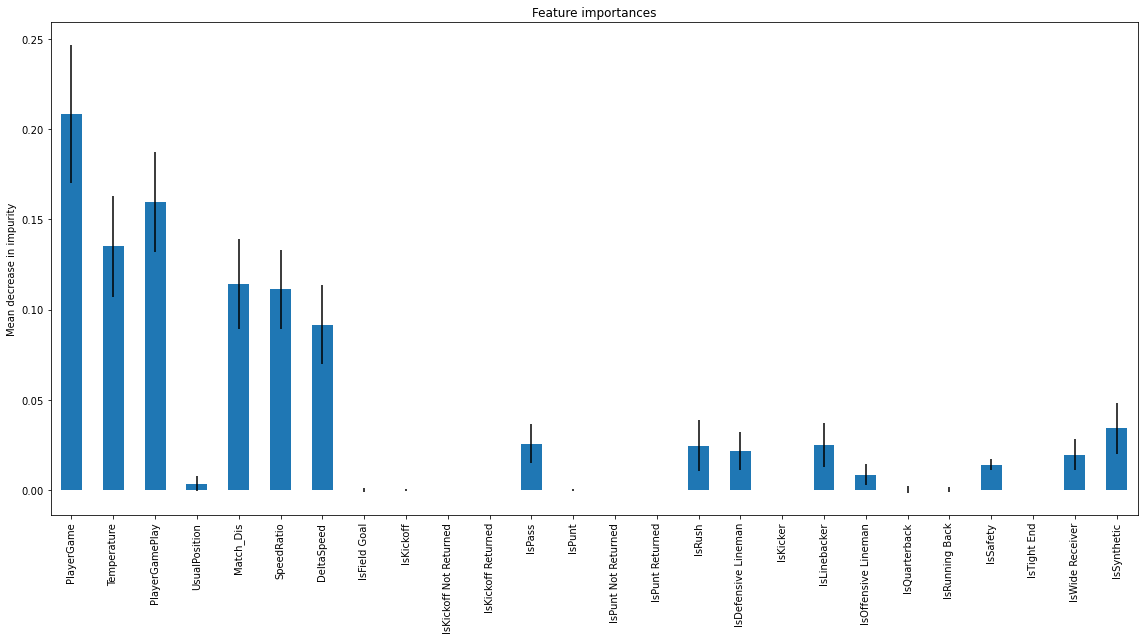

In [108]:
clf = RandomForestClassifier(n_estimators=100 , min_samples_split = 10, min_samples_leaf = 15,
                             max_features =0.75, max_depth = None)
clf.fit(X_train_os, y_train_os)
clf_preds = clf.predict(X_test)

features = X_train_os.columns.values

importances = clf.feature_importances_
forest_importances = pd.Series(importances, index=features)
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

fig, ax = plt.subplots(figsize=(16,9))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

***
## Conclusion <a class="anchor" id="conclusion"></a>

We first cleaned the dataset, not only in order to check on useless values but also to adapt the data to our needs. Then, we used ML algorithm on our dataset, without dealing with our class imbalance. It was the naive approch. Finally, in the last part, we try to predict NFL Injuries considering our class imbalance, we tried to correct by oversampling our dataset.